# Import 

In [ ]:
!pip install spectral  
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.regularizers import l2
import pandas as pd
import numpy as np
from tensorflow import  keras
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import utils #np_utils
from tensorflow.keras.utils import to_categorical

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

import tensorflow as tf
init_notebook_mode(connected=True)
%matplotlib inline

import spectral.io.envi as envi
from spectral import*
import matplotlib.pyplot as plt
import spectral

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
# function that gets the reflectance from intensities 
 
def get_reflectance(image):
  reflectance=np.zeros((image.shape))
  depth=image.shape[2]
  for lamda in range(depth):
    image_layer=image[:,:,lamda]
    radiance=image_layer.mean()
    reflectance[:,:,lamda]=image_layer.reshape(image.shape[:2])/radiance

  return reflectance


In [ ]:
def change_2_triple_input(img_refl):
  # input image 
  img_refl.shape
  # pad image 
  img_refl_padded=np.zeros(  ( img_refl.shape[0] , img_refl.shape[1] + 2       ,  img_refl.shape[2]       ) )
  # create a bigger 
  # fill the inside 
  img_refl_padded[ : , 1:img_refl.shape[1] + 1 ,: ]= img_refl 
  #change to input size triple in each row
  img_refl_input=np.zeros( (img_refl_padded.shape[0]*(img_refl_padded.shape[1]-2),img_refl_padded.shape[2]*3) )
  counter=0
  for row in range(img_refl_padded.shape[0]): 
    for col in range( 1 , img_refl_padded.shape[1]- 1 ):   
      img_refl_input[counter,:] = img_refl_padded[row,col-1:col+2,:].reshape(1,img_refl_padded.shape[2]*3) # double check this step 
      counter=counter + 1;
  return img_refl_input


In [ ]:
def form_label_matrix(img,img_string,df,draw):


  label_matrix_img=np.zeros(img.shape[:2])

  img_labeled=df.loc[img_string,["x","y","label"]]


  ## level one 
  i=0
  img_index_1=np.where(img_labeled["label"] == 'Level 1')

  img_labeled_1=img_labeled[["x","y"]].iloc[ img_index_1[0].tolist() ]

  img_labeled_1_x=img_labeled_1["x"].tolist()
  img_labeled_1_y=img_labeled_1["y"].tolist()

  for i in range(len(img_labeled_1_x)):
    x=int(img_labeled_1_x[i])
    y=int(img_labeled_1_y[i])
    label_matrix_img[y][x]=1

  ## level two
  i=0
  img_index_2=np.where(img_labeled["label"] == 'Level 2')

  img_labeled_2=img_labeled[["x","y"]].iloc[ img_index_2[0].tolist() ]

  img_labeled_2_x=img_labeled_2["x"].tolist()
  img_labeled_2_y=img_labeled_2["y"].tolist()

  for i in range(len(img_labeled_2_x)):
    x=int(img_labeled_2_x[i])
    y=int(img_labeled_2_y[i])
    label_matrix_img[y][x]=2

  ## level 3 
  i=0
  img_index_3=np.where(img_labeled["label"] == 'Level 3')

  img_labeled_3=img_labeled[["x","y"]].iloc[ img_index_3[0].tolist() ]

  img_labeled_3_x=img_labeled_3["x"].tolist()
  img_labeled_3_y=img_labeled_3["y"].tolist()

  for i in range(len(img_labeled_3_x)):
    x=int(img_labeled_3_x[i])
    y=int(img_labeled_3_y[i])
    label_matrix_img[y][x]=3

  ## level 4 
  i=0

  img_index_4=np.where(img_labeled["label"] == 'Level 4')  

  img_labeled_4=img_labeled[["x","y"]].iloc[ img_index_4[0].tolist() ]

  img_labeled_4_x=img_labeled_4["x"].tolist()
  img_labeled_4_y=img_labeled_4["y"].tolist()

  for i in range(len(img_labeled_4_x)):
    x=int(img_labeled_4_x[i])
    y=int(img_labeled_4_y[i])
    label_matrix_img[y][x] = 4



  ## background 
  i=0 

  img_index_b=np.where(img_labeled["label"] == 'shadow') 

  img_labeled_b=img_labeled[["x","y"]].iloc[ img_index_b[0].tolist() ]

  img_labeled_b_x=img_labeled_b["x"].tolist()
  img_labeled_b_y=img_labeled_b["y"].tolist()

  for i in range(len(img_labeled_b_x)):
    x=int(img_labeled_b_x[i])
    y=int(img_labeled_b_y[i])
    label_matrix_img[y][x]=5

  ## sky
  i=0 

  img_index_s=np.where(img_labeled["label"] == 'sky') 

  img_labeled_s=img_labeled[["x","y"]].iloc[ img_index_s[0].tolist() ]

  img_labeled_s_x=img_labeled_s["x"].tolist()
  img_labeled_s_y=img_labeled_s["y"].tolist()

  for i in range(len(img_labeled_s_x)):
    x=int(img_labeled_s_x[i])
    y=int(img_labeled_s_y[i])
    label_matrix_img[y][x]=6

  #draw

  #    no label,1,2, 3, 4 , b,s
  #    black ,  green   , yellow , orange , red  ,    gray, blue
  
  if draw == 1:

    paint_cmap = ListedColormap([  '#050505' , '#AAF803' ,'#F0F803','#F89403', '#FC240A', '#BDBDBD','#0000CD'], name='Level')

        # just a trick
    label_matrix_img_temp = label_matrix_img
    label_matrix_img_temp[0,0]=1
    label_matrix_img_temp[0,1]=2
    label_matrix_img_temp[0,2]=3
    label_matrix_img_temp[0,3]=4
    label_matrix_img_temp[0,4]=5
    label_matrix_img_temp[0,5]=6
    label_matrix_img_temp[0,6]=0

    plt.imshow( label_matrix_img_temp , cmap=paint_cmap) #paint_cmap
    


  return  label_matrix_img
    

In [ ]:
#split data
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [ ]:
def predict_image(img_short,draw):
  # get reflectance 
  reflectance_short=get_reflectance(img_short)
  input_short=change_2_triple_input(reflectance_short)
  


  # predict short 
  predictions_short = model_short.predict(  #### my mistake was here , I put model rather than model short
        #x=scaled_samples_withoutzero
        x=input_short      
      , batch_size=1000 # what is the defualt
      , verbose=0
  )  

  rounded_predictions_short = np.argmax(predictions_short, axis=-1) #review the axis

  y_short_predicted=rounded_predictions_short.reshape(img_short.shape[:2]) #check if correct 

  #    1,2, 3, 4 , b,s
  #    green   , yellow , orange , red  ,    gray, blue

  if draw == 1:

    paint_cmap = ListedColormap([   '#AAF803' ,'#F0F803','#F89403', '#FC240A', '#BDBDBD','#0000CD'], name='Level')


    # just a trick
    y_short_predicted_temp = y_short_predicted
    y_short_predicted_temp[0,0]=1
    y_short_predicted_temp[0,1]=2
    y_short_predicted_temp[0,2]=3
    y_short_predicted_temp[0,3]=4
    y_short_predicted_temp[0,4]=5
    y_short_predicted_temp[0,5]=0

    plt.imshow(y_short_predicted_temp, cmap=paint_cmap) #paint_cmap

    view4 = imshow(img_short, (1, 6, 20),figsize =(7,7))

# Input

In [ ]:
# get full image 
Level1_1_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Level1-1.hdr','/content/drive/MyDrive/sydney_data_long/images/Level1-1.fla')
Level2_1_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Level2-1.hdr','/content/drive/MyDrive/sydney_data_long/images/Level2-1.fla')

Mixture_1_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Mixture-1.hdr','/content/drive/MyDrive/sydney_data_long/images/Mixture-1.fla')
Mixture_2_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Mixture-2.hdr','/content/drive/MyDrive/sydney_data_long/images/Mixture-2.fla')
Mixture_3_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Mixture-3.hdr','/content/drive/MyDrive/sydney_data_long/images/Mixture-3.fla')
Mixture_4_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Mixture-4.hdr','/content/drive/MyDrive/sydney_data_long/images/Mixture-4.fla')
Mixture_5_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Mixture-5.hdr','/content/drive/MyDrive/sydney_data_long/images/Mixture-5.fla')

Peeling_1_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Peeling-1.hdr','/content/drive/MyDrive/sydney_data_long/images/Peeling-1.fla')
Peeling_2_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Peeling-2.hdr','/content/drive/MyDrive/sydney_data_long/images/Peeling-2.fla')
Peeling_3_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Peeling-3.hdr','/content/drive/MyDrive/sydney_data_long/images/Peeling-3.fla')
Peeling_4_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Peeling-4.hdr','/content/drive/MyDrive/sydney_data_long/images/Peeling-4.fla')
Peeling_5_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Peeling-5.hdr','/content/drive/MyDrive/sydney_data_long/images/Peeling-5.fla')
Peeling_6_img= envi.open('/content/drive/MyDrive/sydney_data_long/images/Peeling-6.hdr','/content/drive/MyDrive/sydney_data_long/images/Peeling-6.fla')





In [ ]:
# get full reflectance image 
Level1_1_img_refl=get_reflectance(Level1_1_img)
Level2_1_img_refl=get_reflectance(Level2_1_img)

Mixture_1_img_refl=get_reflectance(Mixture_1_img)
Mixture_2_img_refl=get_reflectance(Mixture_2_img)
Mixture_3_img_refl=get_reflectance(Mixture_3_img)
Mixture_4_img_refl=get_reflectance(Mixture_4_img)
Mixture_5_img_refl=get_reflectance(Mixture_5_img)

Peeling_1_img_refl=get_reflectance(Peeling_1_img)
Peeling_2_img_refl=get_reflectance(Peeling_2_img)
Peeling_3_img_refl=get_reflectance(Peeling_3_img)
Peeling_4_img_refl=get_reflectance(Peeling_4_img)
Peeling_5_img_refl=get_reflectance(Peeling_5_img)
Peeling_6_img_refl=get_reflectance(Peeling_6_img)



In [ ]:
# change to input shape of triples

Level1_1_img_refl_input=change_2_triple_input(Level1_1_img_refl)
Level2_1_img_refl_input=change_2_triple_input(Level2_1_img_refl)

Mixture_1_img_refl_input=change_2_triple_input(Mixture_1_img_refl)
Mixture_2_img_refl_input=change_2_triple_input(Mixture_2_img_refl)
Mixture_3_img_refl_input=change_2_triple_input(Mixture_3_img_refl)
Mixture_4_img_refl_input=change_2_triple_input(Mixture_4_img_refl)
Mixture_5_img_refl_input=change_2_triple_input(Mixture_5_img_refl)

Peeling_1_img_refl_input=change_2_triple_input(Peeling_1_img_refl)
Peeling_2_img_refl_input=change_2_triple_input(Peeling_2_img_refl)
Peeling_3_img_refl_input=change_2_triple_input(Peeling_3_img_refl)
Peeling_4_img_refl_input=change_2_triple_input(Peeling_4_img_refl)
Peeling_5_img_refl_input=change_2_triple_input(Peeling_5_img_refl)
Peeling_6_img_refl_input=change_2_triple_input(Peeling_6_img_refl)


# Label

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/sydney_data_long/paint_rating_10July2014_long_me.csv') 
df = pd.read_csv('/content/drive/MyDrive/sydney_data_long/paint_rating_long_me.csv')  

print(df.head)

df.set_index("image", inplace = True)


<bound method NDFrame.head of             image    x    y    label   450   460   470   480   490   500  ...  \
0       Peeling-3  514  238  Level 3  18.0  26.0  33.0  36.0  38.0  36.0  ...   
1       Peeling-3  515  238  Level 3  18.0  27.0  33.0  37.0  38.0  36.0  ...   
2       Peeling-3  516  238  Level 3  18.0  26.0  34.0  37.0  38.0  36.0  ...   
3       Peeling-3  515  239  Level 3  18.0  27.0  33.0  36.0  38.0  36.0  ...   
4       Peeling-3  516  239  Level 3  18.0  26.0  34.0  36.0  39.0  36.0  ...   
...           ...  ...  ...      ...   ...   ...   ...   ...   ...   ...  ...   
255833  Peeling-2  918  522  Level 3  14.0  20.0  25.0  28.0  31.0  29.0  ...   
255834  Peeling-2  919  522  Level 3  14.0  20.0  25.0  27.0  29.0  30.0  ...   
255835  Peeling-2  920  522  Level 3  14.0  20.0  24.0  26.0  28.0  29.0  ...   
255836  Peeling-2  921  522  Level 3  13.0  20.0  25.0  27.0  28.0  28.0  ...   
255837  Peeling-2  921  523  Level 3  14.0  20.0  25.0  27.0  29.0  29.0  ...  

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.



## image label matrix

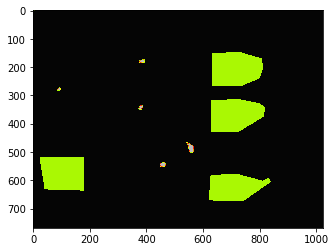

In [ ]:
label_matrix_Level1_1=form_label_matrix(Level1_1_img,"Level1-1",df,1)

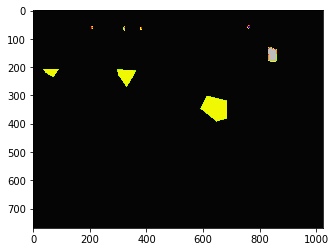

In [ ]:
label_matrix_Level2_1=form_label_matrix(Level2_1_img,"Level2-1",df,1)

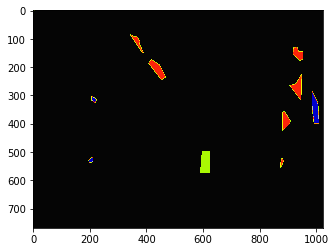

In [ ]:
label_matrix_Mixture_1=form_label_matrix(Mixture_1_img,"Mixture-1",df,1)

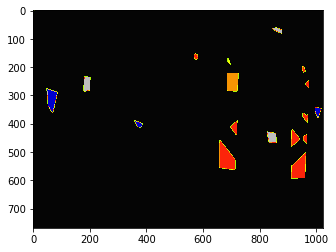

In [ ]:
label_matrix_Mixture_2=form_label_matrix(Mixture_2_img,"Mixture-2",df,1)

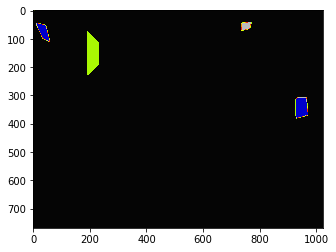

In [ ]:
label_matrix_Mixture_3=form_label_matrix(Mixture_3_img,"Mixture-3",df,1)

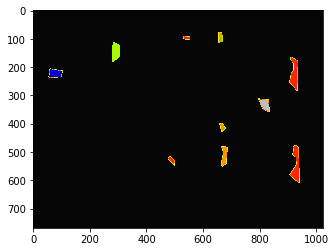

In [ ]:
label_matrix_Mixture_4=form_label_matrix(Mixture_4_img,"Mixture-4",df,1)

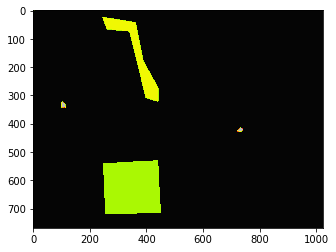

In [ ]:
label_matrix_Mixture_5=form_label_matrix(Mixture_5_img,"Mixture-5",df,1)

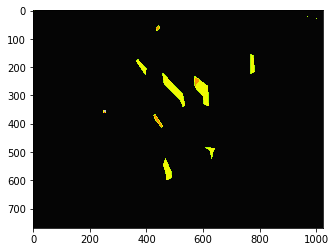

In [ ]:
label_matrix_Peeling_1=form_label_matrix(Peeling_1_img,"Peeling-1",df,1)

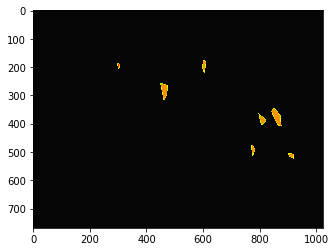

In [ ]:
label_matrix_Peeling_2=form_label_matrix(Peeling_2_img,"Peeling-2",df,1)

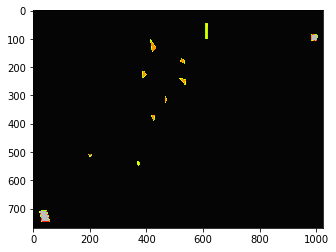

In [ ]:
label_matrix_Peeling_3=form_label_matrix(Peeling_3_img,"Peeling-3",df,1)

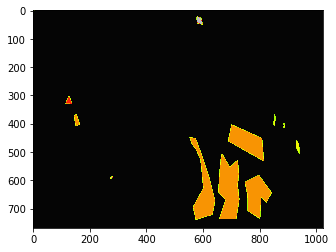

In [ ]:
label_matrix_Peeling_4=form_label_matrix(Peeling_4_img,"Peeling-4",df,1)

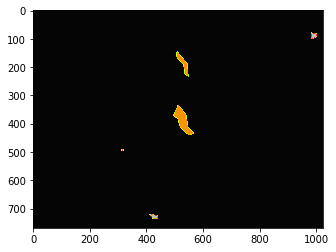

In [ ]:
label_matrix_Peeling_5=form_label_matrix(Peeling_5_img,"Peeling-5",df,1)

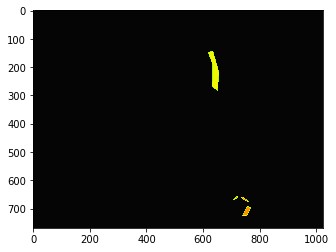

In [ ]:
label_matrix_Peeling_6=form_label_matrix(Peeling_6_img,"Peeling-6",df,1)

## clipping

In [ ]:
def flat_label_matrix(label_matrix):
  label_matrix_flat=label_matrix.reshape( (label_matrix.shape[0]*label_matrix.shape[1],1) )
  return label_matrix_flat


In [ ]:
# flat label matrix 
label_matrix_Level1_1_flat=flat_label_matrix(label_matrix_Level1_1)
label_matrix_Level2_1_flat=flat_label_matrix(label_matrix_Level2_1)

label_matrix_Mixture_1_flat=flat_label_matrix(label_matrix_Mixture_1)
label_matrix_Mixture_2_flat=flat_label_matrix(label_matrix_Mixture_2)
label_matrix_Mixture_3_flat=flat_label_matrix(label_matrix_Mixture_3)
label_matrix_Mixture_4_flat=flat_label_matrix(label_matrix_Mixture_4)
label_matrix_Mixture_5_flat=flat_label_matrix(label_matrix_Mixture_5)



label_matrix_Peeling_1_flat=flat_label_matrix(label_matrix_Peeling_1)
label_matrix_Peeling_2_flat=flat_label_matrix(label_matrix_Peeling_2)
label_matrix_Peeling_3_flat=flat_label_matrix(label_matrix_Peeling_3)
label_matrix_Peeling_4_flat=flat_label_matrix(label_matrix_Peeling_4)
label_matrix_Peeling_5_flat=flat_label_matrix(label_matrix_Peeling_5)
label_matrix_Peeling_6_flat=flat_label_matrix(label_matrix_Peeling_6)

In [ ]:
# remove rows with zero index 
def generate_X_y(img_refl_input,label_matrix_flat):

  index0_list=np.where(label_matrix_flat==0)[0].tolist()
  y_img=np.delete(label_matrix_flat,index0_list,axis=0)
  X_img=np.delete(img_refl_input,index0_list,axis=0)
  

  return X_img,y_img






In [ ]:
X_img_Level1_1,y_img_Level1_1=generate_X_y( Level1_1_img_refl_input , label_matrix_Level1_1_flat )
X_img_Level2_1,y_img_Level2_1=generate_X_y( Level2_1_img_refl_input , label_matrix_Level2_1_flat )

X_img_Mixture_1,y_img_Mixture_1=generate_X_y( Mixture_1_img_refl_input , label_matrix_Mixture_1_flat )
X_img_Mixture_2,y_img_Mixture_2=generate_X_y( Mixture_2_img_refl_input , label_matrix_Mixture_2_flat )
X_img_Mixture_3,y_img_Mixture_3=generate_X_y( Mixture_3_img_refl_input , label_matrix_Mixture_3_flat )
X_img_Mixture_4,y_img_Mixture_4=generate_X_y( Mixture_4_img_refl_input , label_matrix_Mixture_4_flat )
X_img_Mixture_5,y_img_Mixture_5=generate_X_y( Mixture_5_img_refl_input , label_matrix_Mixture_5_flat )

X_img_Peeling_1,y_img_Peeling_1=generate_X_y( Peeling_1_img_refl_input , label_matrix_Peeling_1_flat )
X_img_Peeling_2,y_img_Peeling_2=generate_X_y( Peeling_2_img_refl_input , label_matrix_Peeling_2_flat )
X_img_Peeling_3,y_img_Peeling_3=generate_X_y( Peeling_3_img_refl_input , label_matrix_Peeling_3_flat )
X_img_Peeling_4,y_img_Peeling_4=generate_X_y( Peeling_4_img_refl_input , label_matrix_Peeling_4_flat )
X_img_Peeling_5,y_img_Peeling_5=generate_X_y( Peeling_5_img_refl_input , label_matrix_Peeling_5_flat )
X_img_Peeling_6,y_img_Peeling_6=generate_X_y( Peeling_6_img_refl_input , label_matrix_Peeling_6_flat )




In [ ]:
# concatinate 
X = np.concatenate((X_img_Level1_1,X_img_Level2_1, X_img_Mixture_1 ,X_img_Mixture_2 ,X_img_Mixture_3 ,X_img_Mixture_4 ,X_img_Mixture_5 ,X_img_Peeling_1,X_img_Peeling_2,X_img_Peeling_3,X_img_Peeling_4,X_img_Peeling_5,X_img_Peeling_6),0)
#concatinate triplets
y = np.concatenate((y_img_Level1_1,y_img_Level2_1, y_img_Mixture_1 ,y_img_Mixture_2 ,y_img_Mixture_3 ,y_img_Mixture_4 ,y_img_Mixture_5 ,y_img_Peeling_1,y_img_Peeling_2,y_img_Peeling_3,y_img_Peeling_4,y_img_Peeling_5,y_img_Peeling_6),0)


In [ ]:
#shuffel 
## shuffle 
def my_shuff(X,y):
  X_shuf=np.zeros(X.shape)
  y_shuf=np.zeros(y.shape)

  arr = np.arange(len(y))
  np.random.shuffle(arr)
  counter=0

  for i in arr:
    X_shuf[counter,:]=X[i,:]
    y_shuf[counter]=y[i]
    counter=counter+1;
  
  return X_shuf,y_shuf


In [ ]:
#shuffel
X_shuf,y_shuf=my_shuff(X,y)
X_shuf,y_shuf=my_shuff(X_shuf,y_shuf)
X_shuf,y_shuf=my_shuff(X_shuf,y_shuf)

In [ ]:
# data split 
X_train, X_test, y_train, y_test=splitTrainTestSet(X_shuf,y_shuf, testRatio=0.1, randomState=345) 

# Training

In [ ]:
#train a smaller model for spectral only 
K=X_train.shape[1]
model = Sequential([
    Dense(units=128, input_shape=(K,), activation='relu'), #was 30 # added 128 rather than 64
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)), # %%%%%%%%%%%%%%%%%%%%% added this
    Dense(units=32, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=16, activation='relu',bias_regularizer=l2(0.01)),
    #Dropout(0.2),    
    Dense(units=6, activation='softmax') # change to right classssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss 
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #reviw  0.0001
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8192      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 6)                 102       
                                                                 
Total params: 19,158
Trainable params: 19,158
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#train a smaller model for spectral only 
K=X_train.shape[1]
model = Sequential([
    Dense(units=128, input_shape=(K,), activation='relu'), #was 30 # added 128 rather than 64
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)), # %%%%%%%%%%%%%%%%%%%%% added this
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)), # %%%%%%%%%%%%%%%%%%%%% added this
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)), # %%%%%%%%%%%%%%%%%%%%% added this
    Dense(units=64, activation='relu',bias_regularizer=l2(0.01)), # %%%%%%%%%%%%%%%%%%%%% added this
    Dense(units=32, activation='relu',bias_regularizer=l2(0.01)),
    Dense(units=16, activation='relu',bias_regularizer=l2(0.01)),
    #Dropout(0.2),    
    Dense(units=6, activation='softmax') # change to right classssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss 
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #reviw  0.0001
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8192      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                5

In [ ]:
model.fit(
      x=X_train
    , y=y_train - 1 # pay attention in following steps 
    , validation_split=0.1
    , batch_size=10
    , epochs=300
    , verbose=2
)

Epoch 1/300
20700/20700 - 45s - loss: 0.6717 - accuracy: 0.7241 - val_loss: 0.6412 - val_accuracy: 0.7315 - 45s/epoch - 2ms/step
Epoch 2/300
20700/20700 - 37s - loss: 0.5319 - accuracy: 0.7805 - val_loss: 0.4973 - val_accuracy: 0.7936 - 37s/epoch - 2ms/step
Epoch 3/300
20700/20700 - 37s - loss: 0.4379 - accuracy: 0.8282 - val_loss: 0.4061 - val_accuracy: 0.8382 - 37s/epoch - 2ms/step
Epoch 4/300
20700/20700 - 40s - loss: 0.3908 - accuracy: 0.8466 - val_loss: 0.3519 - val_accuracy: 0.8625 - 40s/epoch - 2ms/step
Epoch 5/300
20700/20700 - 37s - loss: 0.3609 - accuracy: 0.8586 - val_loss: 0.3447 - val_accuracy: 0.8647 - 37s/epoch - 2ms/step
Epoch 6/300
20700/20700 - 38s - loss: 0.3426 - accuracy: 0.8664 - val_loss: 0.3140 - val_accuracy: 0.8779 - 38s/epoch - 2ms/step
Epoch 7/300
20700/20700 - 37s - loss: 0.3256 - accuracy: 0.8725 - val_loss: 0.3003 - val_accuracy: 0.8836 - 37s/epoch - 2ms/step
Epoch 8/300
20700/20700 - 37s - loss: 0.3129 - accuracy: 0.8779 - val_loss: 0.3127 - val_accuracy

# save model

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('DNN_sydney_Longrange_mypreprocessing_spsp_300epochs_new_96')

INFO:tensorflow:Assets written to: DNN_sydney_Longrange_mypreprocessing_spsp_300epochs_new_96/assets


# Testing

## on test dataset 

In [ ]:

model_short=keras.models.load_model('/content/drive/MyDrive/DNN_sydney_Longrange_mypreprocessing_spsp_300epochs_new_96')

In [ ]:

predictions = model_short.predict(
      #x=scaled_samples_withoutzero
      x=X_test #X_test      
    , batch_size=1000 # what is the defualt
    , verbose=0
)  

rounded_predictions = np.argmax(predictions, axis=-1) #review the axis


target_names = ['Level 1','Level 2','Level 3','Level 4','background','sky']
print( classification_report( y_test - 1 , rounded_predictions,target_names=target_names ) )


              precision    recall  f1-score   support

     Level 1       0.96      0.98      0.97     12032
     Level 2       0.93      0.94      0.93      3564
     Level 3       0.95      0.90      0.92      5559
     Level 4       0.97      0.98      0.98      2275
  background       0.99      1.00      1.00      1024
         sky       1.00      1.00      1.00      1101

    accuracy                           0.96     25555
   macro avg       0.97      0.97      0.97     25555
weighted avg       0.96      0.96      0.96     25555



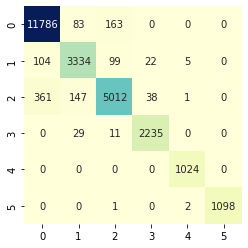

In [ ]:
import seaborn as sns
matrix_confusion = confusion_matrix(y_test-1, rounded_predictions)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='YlGnBu', fmt='d', cbar=False)

## on images

In [ ]:
draw=1
  #  1,2, 3, 4 , b,s


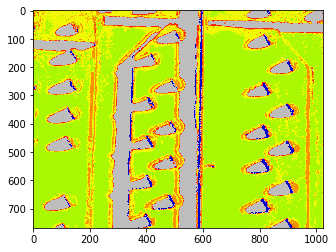

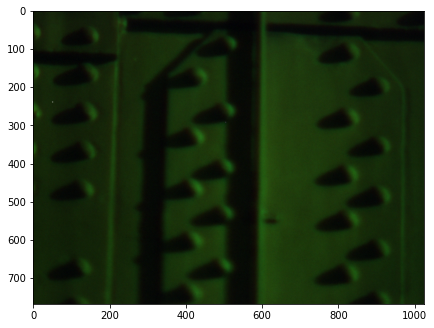

In [ ]:
predict_image(Level1_1_img,draw)

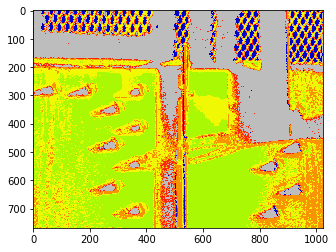

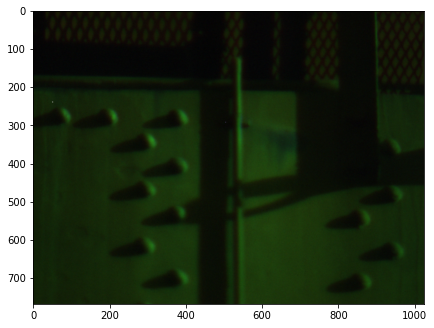

In [ ]:
predict_image(Level2_1_img,draw)

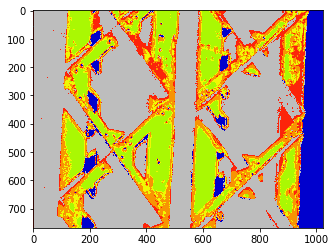

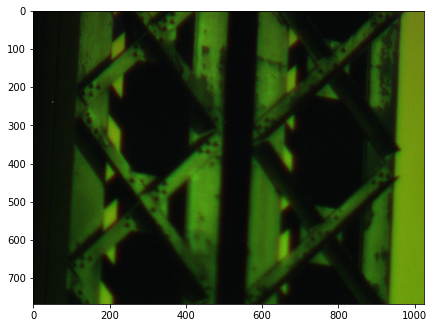

In [ ]:
predict_image(Mixture_1_img,draw)

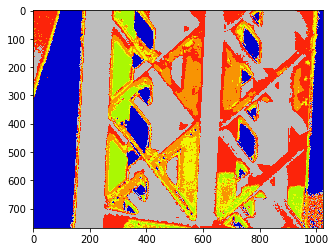

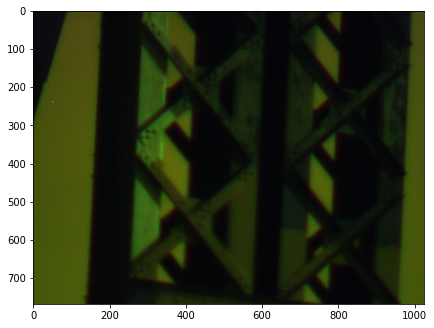

In [ ]:
predict_image(Mixture_2_img,draw)

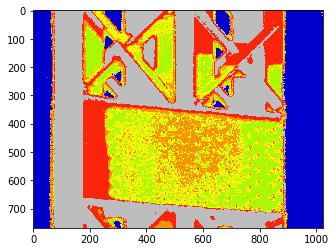

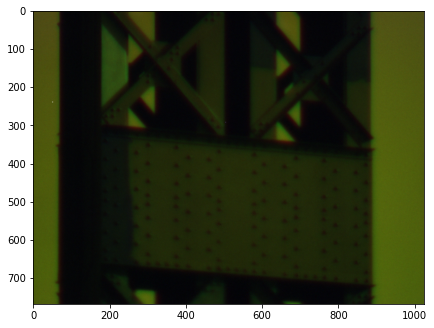

In [ ]:
predict_image(Mixture_3_img,draw)

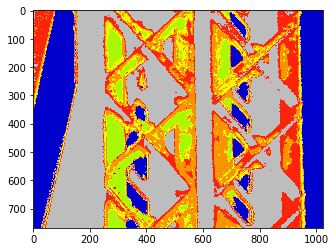

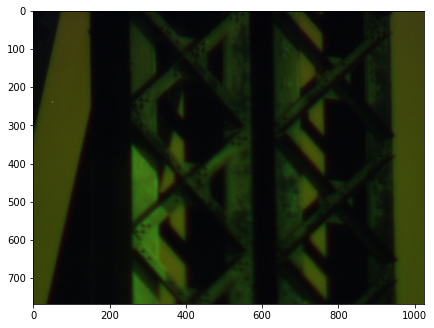

In [ ]:
predict_image(Mixture_4_img,draw)

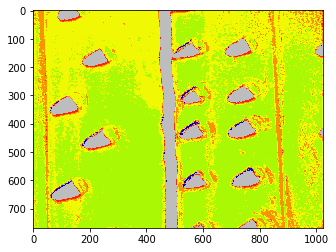

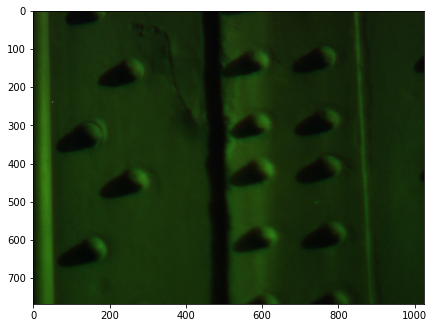

In [ ]:
predict_image(Mixture_5_img,draw)

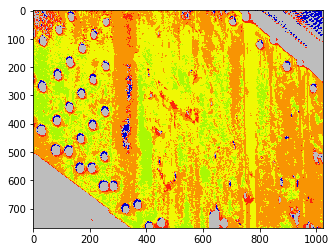

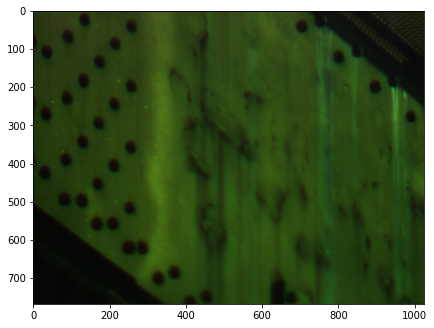

In [ ]:
predict_image(Peeling_1_img,draw)

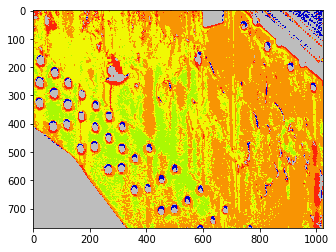

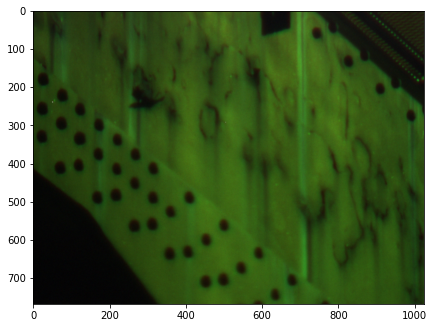

In [ ]:
predict_image(Peeling_2_img,draw)

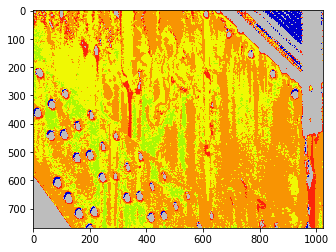

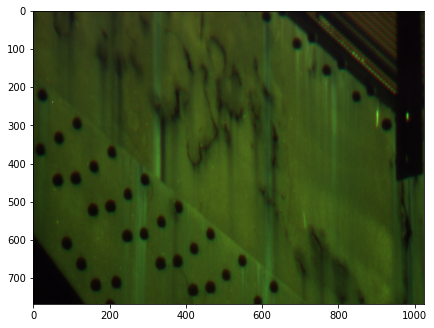

In [ ]:
predict_image(Peeling_3_img,draw)

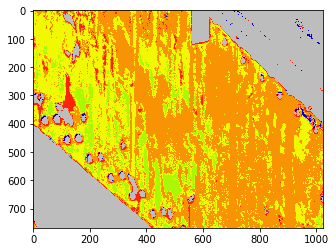

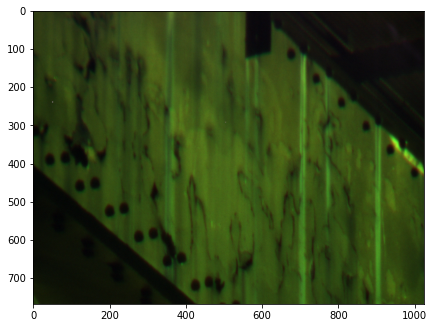

In [ ]:
predict_image(Peeling_4_img,draw)

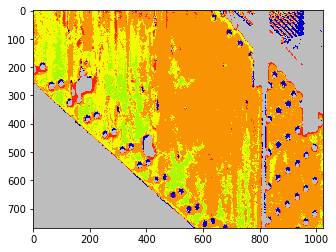

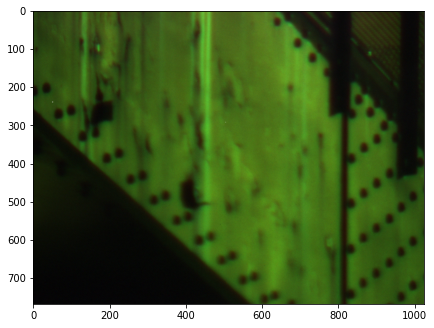

In [ ]:
predict_image(Peeling_5_img,draw)